In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
os.listdir()

['run_2_dense_2gb.txt',
 'run_1_dense_4gb.txt',
 'run_7_dense_128mb.txt',
 'run_6_dense_256mb.txt',
 'run_4_dense_512mb.txt',
 'run_10_dense_16mb.txt',
 'run_5_dense_4mb.txt',
 'run_8_dense_64mb.txt',
 'run_3_dense_1gb.txt',
 'run_9_dense_32mb.txt',
 '.ipynb_checkpoints',
 'M1_and_M2_Regression.ipynb']

In [3]:
def parse_memory(memory):
    num = 0
    if 'gb' in memory:
        num = int(memory.replace('gb', '')) * 1000000000
    if 'mb' in memory:
        num = int(memory.replace('mb', '')) * 1000000
    return num

dfs = {}
for benchmark in os.listdir():
    if benchmark.endswith('.txt'):
        memory = benchmark.split('.')[0].split('_')[-1]
        df = pd.read_csv(benchmark, delimiter=" ", names=['input_size', 'output_size', 'time'])
        df['memory'] = df['time'].apply(lambda _: parse_memory(memory))
        dfs[memory] = df

In [4]:
df = pd.concat(dfs.values())
df.sample(10)

,input_size,output_size,time,memory
2,2,8,8.08872389793,32000000
18,4,128,198.002413034,32000000
41,16,64,5.34844708443,1000000000
14,4,8,2.68569517136,128000000
40,16,32,4.62574195862,512000000
26,8,8,7.67458605766,256000000
1,2,4,1.92365908623,2000000000
22,4,2048,41.7679269314,64000000
28,8,32,3.3385310173,512000000
8,2,512,496.345736027,16000000


In [9]:
df.shape

(384, 4)

In [10]:
df.loc[36][df.loc[36]['time'] != 'Killed']['memory']

36    2000000000
36    4000000000
36     512000000
36    1000000000
Name: memory, dtype: int64

In [11]:
df.loc[48]

,input_size,output_size,time,memory
48,32,2,Killed,2000000000
48,32,2,5.45444512367,4000000000
48,32,2,Killed,512000000
48,32,2,Killed,1000000000


In [12]:
m1_df = pd.DataFrame(columns=['input_size', 'output_size', 'm_1'])
for idx in set(df.index):
    mem_df = df.loc[idx]
    if isinstance(mem_df, pd.Series):
        mem_df = mem_df.to_frame().transpose()
#         print(idx, mem_df['memory'].iloc[0])
        if mem_df['time'].iloc[0] == 'Killed':
            continue
#         print(mem_df)
        m1_df = m1_df.append({
            'input_size': mem_df['input_size'].iloc[0],
            'output_size': mem_df['output_size'].iloc[0],
            'm_1': mem_df['memory'].iloc[0]
        }, ignore_index=True)
        continue
#     print(idx)
    m1 = min(mem_df[mem_df['time'] != 'Killed']['memory'])
#     print(mem_df)
#     appended = pd.DataFrame()
#     print(appended)
    m1_df = m1_df.append({
        'input_size': mem_df['input_size'].iloc[0],
        'output_size': mem_df['output_size'].iloc[0],
        'm_1': m1
    }, ignore_index=True)
#     print(idx)
m1_df.head(10)

,input_size,output_size,m_1
0,2,2,4000000
1,2,4,4000000
2,2,8,16000000
3,2,16,16000000
4,2,32,16000000
5,2,64,16000000
6,2,128,16000000
7,2,256,16000000
8,2,512,16000000
9,2,1024,16000000


In [13]:
m1_df.tail(15)

,input_size,output_size,m_1
45,16,1024,512000000
46,16,2048,512000000
47,16,4096,512000000
48,32,2,4000000000
49,32,4,4000000000
50,32,8,4000000000
51,32,16,4000000000
52,32,32,4000000000
53,32,64,4000000000
54,32,128,4000000000


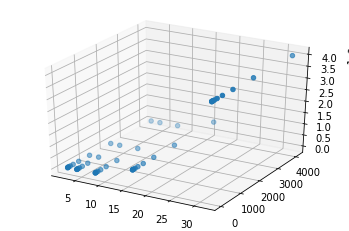

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m1_df['input_size'], m1_df['output_size'], m1_df['m_1'])

plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


In [23]:
def random_forest(data, pred_column):
    
    X = data.drop([pred_column], axis=1)  # Features
    y = data[pred_column]  # Labels

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train);
    
    
    y_pred = rf.predict(X_test)

    print("MSE:", mean_squared_error(y_test, y_pred))

    test_results = pd.concat([X_test, pd.DataFrame({'actual': y_test, 'pred': y_pred})], axis=1)

    return rf, test_results

In [24]:
m1_regressor, test_results = random_forest(m1_df, 'm_1')

MSE: 5411337777777.777


In [25]:
test_results

,input_size,output_size,actual,pred
45,16,1024,512000000,5.120000e+08
15,4,16,16000000,1.582000e+07
11,2,4096,16000000,1.597600e+07
14,4,8,16000000,1.550800e+07
33,8,1024,32000000,3.200000e+07
23,4,4096,16000000,1.600000e+07
20,4,512,16000000,1.600000e+07
52,32,32,4000000000,3.996512e+09
21,4,1024,16000000,1.600000e+07
28,8,32,32000000,3.200000e+07


In [28]:
no_kill = df[df['time'] != 'Killed']
times = no_kill.copy()
times['time'] = no_kill['time'].astype('float64')
times.head()

,input_size,output_size,time,memory
0,2,2,1.951727,2000000000
1,2,4,1.923659,2000000000
2,2,8,1.919863,2000000000
3,2,16,1.955691,2000000000
4,2,32,2.026811,2000000000


In [85]:
pd.set_option('display.max_rows', 500)

for idx in set(df.index):
    display(df.loc[idx].sort_values('memory', ascending=False))

,input_size,output_size,time,memory
0,2,2,1.85009002686,4000000000
0,2,2,1.95172691345,2000000000
0,2,2,1.88879418373,1000000000
0,2,2,1.92143988609,512000000
0,2,2,3.04621601105,256000000
0,2,2,4.27286505699,128000000
0,2,2,8.30674600601,64000000
0,2,2,15.4159548283,32000000
0,2,2,174.095374107,16000000
0,2,2,8021.4338758,4000000


,input_size,output_size,time,memory
1,2,4,1.87558889389,4000000000
1,2,4,1.92365908623,2000000000
1,2,4,1.83615708351,1000000000
1,2,4,1.85764098167,512000000
1,2,4,1.69688391685,256000000
1,2,4,1.7478761673,128000000
1,2,4,2.61660218239,64000000
1,2,4,6.78181409836,32000000
1,2,4,185.656107903,16000000
1,2,4,8070.79026294,4000000


,input_size,output_size,time,memory
2,2,8,1.90290999413,4000000000
2,2,8,1.91986298561,2000000000
2,2,8,1.88248491287,1000000000
2,2,8,1.91189289093,512000000
2,2,8,1.74319791794,256000000
2,2,8,1.73303318024,128000000
2,2,8,2.07452917099,64000000
2,2,8,8.08872389793,32000000
2,2,8,180.63112998,16000000
2,2,8,Killed,4000000


,input_size,output_size,time,memory
3,2,16,1.96692800522,4000000000
3,2,16,1.95569086075,2000000000
3,2,16,2.08320903778,1000000000
3,2,16,1.92254900932,512000000
3,2,16,1.74071598053,256000000
3,2,16,1.7517080307,128000000
3,2,16,4.11441302299,64000000
3,2,16,12.8869020939,32000000
3,2,16,191.00129199,16000000


,input_size,output_size,time,memory
4,2,32,2.19697093964,4000000000
4,2,32,2.02681088448,2000000000
4,2,32,2.01621603966,1000000000
4,2,32,1.96326494217,512000000
4,2,32,1.81972503662,256000000
4,2,32,1.84944105148,128000000
4,2,32,5.54804110527,64000000
4,2,32,12.6011741161,32000000
4,2,32,215.276565075,16000000


,input_size,output_size,time,memory
5,2,64,2.24359297752,4000000000
5,2,64,2.02799105644,2000000000
5,2,64,2.07866382599,1000000000
5,2,64,2.10154008865,512000000
5,2,64,1.85919499397,256000000
5,2,64,2.19303512573,128000000
5,2,64,5.47598695755,64000000
5,2,64,13.8864779472,32000000
5,2,64,429.317330837,16000000


,input_size,output_size,time,memory
6,2,128,2.29076910019,4000000000
6,2,128,2.22403097153,2000000000
6,2,128,2.27336621284,1000000000
6,2,128,2.19267702103,512000000
6,2,128,2.02236294746,256000000
6,2,128,4.25456595421,128000000
6,2,128,14.5318889618,64000000
6,2,128,30.3861119747,32000000
6,2,128,282.298012972,16000000


,input_size,output_size,time,memory
7,2,256,2.57044196129,4000000000
7,2,256,2.33432412148,2000000000
7,2,256,2.42706799507,1000000000
7,2,256,2.35114693642,512000000
7,2,256,2.15652298927,256000000
7,2,256,2.23123717308,128000000
7,2,256,8.02950501442,64000000
7,2,256,19.5845758915,32000000
7,2,256,593.837477922,16000000


,input_size,output_size,time,memory
8,2,512,3.57776999474,4000000000
8,2,512,3.4755461216,2000000000
8,2,512,3.62355995178,1000000000
8,2,512,3.50868201256,512000000
8,2,512,3.12476992607,256000000
8,2,512,3.19325399399,128000000
8,2,512,9.5824649334,64000000
8,2,512,24.1258049011,32000000
8,2,512,496.345736027,16000000


,input_size,output_size,time,memory
9,2,1024,4.64938092232,4000000000
9,2,1024,4.23868012428,2000000000
9,2,1024,4.52568292618,1000000000
9,2,1024,4.40996813774,512000000
9,2,1024,4.14840602875,256000000
9,2,1024,4.15043997765,128000000
9,2,1024,11.031031847,64000000
9,2,1024,30.5732700825,32000000
9,2,1024,1097.40145493,16000000


,input_size,output_size,time,memory
10,2,2048,6.31518602371,4000000000
10,2,2048,6.1905169487,2000000000
10,2,2048,6.09338593483,1000000000
10,2,2048,5.98572301865,512000000
10,2,2048,5.54721498489,256000000
10,2,2048,5.60788106918,128000000
10,2,2048,13.3638432026,64000000
10,2,2048,133.367588997,32000000
10,2,2048,1337.06377411,16000000


,input_size,output_size,time,memory
11,2,4096,9.5096988678,4000000000
11,2,4096,9.41826415062,2000000000
11,2,4096,9.32404208183,1000000000
11,2,4096,9.13850402832,512000000
11,2,4096,8.3832821846,256000000
11,2,4096,9.26041102409,128000000
11,2,4096,18.0847070217,64000000
11,2,4096,154.659501076,32000000
11,2,4096,1659.11910486,16000000


,input_size,output_size,time,memory
12,4,2,2.34738612175,4000000000
12,4,2,2.17631983757,2000000000
12,4,2,2.17323708534,1000000000
12,4,2,2.16223406792,512000000
12,4,2,3.53249502182,256000000
12,4,2,4.19519591331,128000000
12,4,2,14.867305994,64000000
12,4,2,43.5731220245,32000000
12,4,2,775.480659962,16000000


,input_size,output_size,time,memory
13,4,4,2.34492301941,4000000000
13,4,4,2.30130290985,2000000000
13,4,4,2.36520290375,1000000000
13,4,4,2.21477603912,512000000
13,4,4,2.4892680645,256000000
13,4,4,9.92174291611,128000000
13,4,4,30.1847109795,64000000
13,4,4,71.4624180794,32000000
13,4,4,593.717950106,16000000


,input_size,output_size,time,memory
14,4,8,2.29403805733,4000000000
14,4,8,2.29004120827,2000000000
14,4,8,2.20319890976,1000000000
14,4,8,2.15757107735,512000000
14,4,8,2.01127910614,256000000
14,4,8,2.68569517136,128000000
14,4,8,18.0141310692,64000000
14,4,8,58.9751250744,32000000
14,4,8,515.433497906,16000000


,input_size,output_size,time,memory
15,4,16,2.37276387215,4000000000
15,4,16,2.25950288773,2000000000
15,4,16,2.31066298485,1000000000
15,4,16,2.2308819294,512000000
15,4,16,2.02340912819,256000000
15,4,16,2.46199512482,128000000
15,4,16,20.2184150219,64000000
15,4,16,73.4237849712,32000000
15,4,16,672.534445047,16000000


,input_size,output_size,time,memory
16,4,32,2.487210989,4000000000
16,4,32,2.386095047,2000000000
16,4,32,2.36573696136,1000000000
16,4,32,2.25131201744,512000000
16,4,32,2.06794905663,256000000
16,4,32,3.99457287788,128000000
16,4,32,21.9907910824,64000000
16,4,32,84.1443271637,32000000
16,4,32,619.4258039,16000000


,input_size,output_size,time,memory
17,4,64,2.55769395828,4000000000
17,4,64,2.44858407974,2000000000
17,4,64,2.44395303726,1000000000
17,4,64,2.4228079319,512000000
17,4,64,2.18567299843,256000000
17,4,64,4.11066007614,128000000
17,4,64,32.1951849461,64000000
17,4,64,97.6361498833,32000000
17,4,64,761.989015102,16000000


,input_size,output_size,time,memory
18,4,128,3.10480809212,4000000000
18,4,128,2.89945697784,2000000000
18,4,128,2.89839315414,1000000000
18,4,128,2.79560685158,512000000
18,4,128,2.58379817009,256000000
18,4,128,4.65896201134,128000000
18,4,128,25.5696511269,64000000
18,4,128,198.002413034,32000000
18,4,128,743.593962908,16000000


,input_size,output_size,time,memory
19,4,256,3.64697909355,4000000000
19,4,256,3.54164004326,2000000000
19,4,256,3.6064209938,1000000000
19,4,256,3.4891037941,512000000
19,4,256,3.20984101295,256000000
19,4,256,16.8998939991,128000000
19,4,256,48.3983399868,64000000
19,4,256,416.195878983,32000000
19,4,256,1043.67360115,16000000


,input_size,output_size,time,memory
20,4,512,4.32090783119,4000000000
20,4,512,4.12449502945,2000000000
20,4,512,4.40562295914,1000000000
20,4,512,4.20379710197,512000000
20,4,512,3.88983917236,256000000
20,4,512,8.73413395882,128000000
20,4,512,31.696928978,64000000
20,4,512,235.654667139,32000000
20,4,512,1250.68355107,16000000


,input_size,output_size,time,memory
21,4,1024,5.71280694008,4000000000
21,4,1024,5.1680560112,2000000000
21,4,1024,5.25323200226,1000000000
21,4,1024,5.25479602814,512000000
21,4,1024,5.0449719429,256000000
21,4,1024,10.6956350803,128000000
21,4,1024,37.0192279816,64000000
21,4,1024,396.664526939,32000000
21,4,1024,1346.26888418,16000000


,input_size,output_size,time,memory
22,4,2048,8.92291688919,4000000000
22,4,2048,8.42412400246,2000000000
22,4,2048,8.43852591515,1000000000
22,4,2048,8.45667004585,512000000
22,4,2048,7.71297192574,256000000
22,4,2048,13.3395400047,128000000
22,4,2048,41.7679269314,64000000
22,4,2048,375.389744043,32000000
22,4,2048,1967.29196596,16000000


,input_size,output_size,time,memory
23,4,4096,14.6629340649,4000000000
23,4,4096,14.324005127,2000000000
23,4,4096,14.4232299328,1000000000
23,4,4096,14.350787878,512000000
23,4,4096,13.2440671921,256000000
23,4,4096,20.5530860424,128000000
23,4,4096,51.833573103,64000000
23,4,4096,695.450132847,32000000
23,4,4096,2096.23264408,16000000


,input_size,output_size,time,memory
24,8,2,2.67392206192,4000000000
24,8,2,2.606539011,2000000000
24,8,2,2.62517690659,1000000000
24,8,2,2.45404815674,512000000
24,8,2,4.19063091278,256000000
24,8,2,17.0567159653,128000000
24,8,2,47.5822060108,64000000
24,8,2,283.492143154,32000000
24,8,2,Killed,16000000


,input_size,output_size,time,memory
25,8,4,2.89224910736,4000000000
25,8,4,2.77097392082,2000000000
25,8,4,2.52805900574,1000000000
25,8,4,2.29936099052,512000000
25,8,4,2.40726900101,256000000
25,8,4,18.5944969654,128000000
25,8,4,52.6285779476,64000000
25,8,4,295.91074419,32000000


,input_size,output_size,time,memory
26,8,8,2.97456407547,4000000000
26,8,8,2.83276700974,2000000000
26,8,8,2.71393299103,1000000000
26,8,8,2.52528190613,512000000
26,8,8,7.67458605766,256000000
26,8,8,42.1178188324,128000000
26,8,8,85.1835141182,64000000
26,8,8,365.7889328,32000000


,input_size,output_size,time,memory
27,8,16,2.94571304321,4000000000
27,8,16,3.0870718956,2000000000
27,8,16,2.78480100632,1000000000
27,8,16,2.71810293198,512000000
27,8,16,2.86330008507,256000000
27,8,16,24.3186540604,128000000
27,8,16,61.8372690678,64000000
27,8,16,334.105132103,32000000


,input_size,output_size,time,memory
28,8,32,3.59627795219,4000000000
28,8,32,3.62503814697,2000000000
28,8,32,3.4524409771,1000000000
28,8,32,3.3385310173,512000000
28,8,32,3.34118700027,256000000
28,8,32,25.1877679825,128000000
28,8,32,72.1432209015,64000000
28,8,32,457.906445026,32000000


,input_size,output_size,time,memory
29,8,64,3.7672970295,4000000000
29,8,64,3.84481215477,2000000000
29,8,64,3.61852312088,1000000000
29,8,64,3.55493283272,512000000
29,8,64,3.35107111931,256000000
29,8,64,26.743240118,128000000
29,8,64,79.6608190536,64000000
29,8,64,345.018854856,32000000


,input_size,output_size,time,memory
30,8,128,4.1956949234,4000000000
30,8,128,4.12871003151,2000000000
30,8,128,4.16470193863,1000000000
30,8,128,4.00400185585,512000000
30,8,128,3.80515599251,256000000
30,8,128,29.8799419403,128000000
30,8,128,88.5155880451,64000000
30,8,128,378.646278858,32000000


,input_size,output_size,time,memory
31,8,256,4.97842121124,4000000000
31,8,256,4.93104600906,2000000000
31,8,256,4.9342520237,1000000000
31,8,256,4.87939715385,512000000
31,8,256,4.62995100021,256000000
31,8,256,32.1461269855,128000000
31,8,256,98.3941950798,64000000
31,8,256,552.594982862,32000000


,input_size,output_size,time,memory
32,8,512,6.99162006378,4000000000
32,8,512,6.40588903427,2000000000
32,8,512,6.62960886955,1000000000
32,8,512,6.57944178581,512000000
32,8,512,6.51696896553,256000000
32,8,512,35.2616081238,128000000
32,8,512,114.851878881,64000000
32,8,512,503.516093969,32000000


,input_size,output_size,time,memory
33,8,1024,11.0245790482,4000000000
33,8,1024,10.3736081123,2000000000
33,8,1024,10.3841118813,1000000000
33,8,1024,10.4557929039,512000000
33,8,1024,11.2073180676,256000000
33,8,1024,41.0814881325,128000000
33,8,1024,128.238480091,64000000
33,8,1024,503.945772886,32000000


,input_size,output_size,time,memory
34,8,2048,18.1164970398,4000000000
34,8,2048,18.021572113,2000000000
34,8,2048,17.9014289379,1000000000
34,8,2048,18.0365600586,512000000
34,8,2048,24.808245182,256000000
34,8,2048,72.372879982,128000000
34,8,2048,180.590753078,64000000
34,8,2048,992.043493986,32000000


,input_size,output_size,time,memory
35,8,4096,34.4203150272,4000000000
35,8,4096,33.2437450886,2000000000
35,8,4096,33.3823821545,1000000000
35,8,4096,33.5216639042,512000000
35,8,4096,34.996325016,256000000
35,8,4096,65.1731760502,128000000
35,8,4096,259.560492039,64000000
35,8,4096,2063.07041907,32000000


,input_size,output_size,time,memory
36,16,2,3.33787202835,4000000000
36,16,2,3.17242598534,2000000000
36,16,2,3.31241488457,1000000000
36,16,2,8.87534618378,512000000
36,16,2,Killed,256000000
36,16,2,Killed,128000000
36,16,2,Killed,64000000
36,16,2,Killed,32000000


,input_size,output_size,time,memory
37,16,4,3.42630600929,4000000000
37,16,4,3.33335399628,2000000000
37,16,4,3.4038040638,1000000000
37,16,4,3.49918699265,512000000


,input_size,output_size,time,memory
38,16,8,3.48366689682,4000000000
38,16,8,3.48131608963,2000000000
38,16,8,3.42998790741,1000000000
38,16,8,3.5556948185,512000000


,input_size,output_size,time,memory
39,16,16,3.8870279789,4000000000
39,16,16,3.90174794197,2000000000
39,16,16,3.88429689407,1000000000
39,16,16,3.97778916359,512000000


,input_size,output_size,time,memory
40,16,32,4.58310508728,4000000000
40,16,32,4.62919402122,2000000000
40,16,32,4.58572912216,1000000000
40,16,32,4.62574195862,512000000


,input_size,output_size,time,memory
41,16,64,5.40463614464,4000000000
41,16,64,5.31868600845,2000000000
41,16,64,5.34844708443,1000000000
41,16,64,5.19846391678,512000000


,input_size,output_size,time,memory
42,16,128,6.88949584961,4000000000
42,16,128,6.61082983017,2000000000
42,16,128,6.65998482704,1000000000
42,16,128,6.43450307846,512000000


,input_size,output_size,time,memory
43,16,256,9.75457787514,4000000000
43,16,256,9.59749507904,2000000000
43,16,256,9.59329199791,1000000000
43,16,256,9.43129992485,512000000


,input_size,output_size,time,memory
44,16,512,15.8837361336,4000000000
44,16,512,16.1365301609,2000000000
44,16,512,16.5865180492,1000000000
44,16,512,16.2228651047,512000000


,input_size,output_size,time,memory
45,16,1024,33.7130568027,4000000000
45,16,1024,30.2611610889,2000000000
45,16,1024,30.8260121346,1000000000
45,16,1024,42.3673069477,512000000


,input_size,output_size,time,memory
46,16,2048,63.5656888485,4000000000
46,16,2048,57.3876261711,2000000000
46,16,2048,57.4223611355,1000000000
46,16,2048,62.4922869205,512000000


,input_size,output_size,time,memory
47,16,4096,118.885662794,4000000000
47,16,4096,104.870210886,2000000000
47,16,4096,105.557472229,1000000000
47,16,4096,115.563807011,512000000


,input_size,output_size,time,memory
48,32,2,5.45444512367,4000000000
48,32,2,Killed,2000000000
48,32,2,Killed,1000000000
48,32,2,Killed,512000000


ValueError: No axis named memory for object type <class 'type'>

In [99]:
m2 = pd.read_csv('m2.csv')
m2.head()

m2_df = pd.DataFrame(columns=['input_size', 'output_size', 'm_2'])
for idx in set(df.index):
    mem_df = df.loc[idx]
    if isinstance(mem_df, pd.Series):
        mem_df = mem_df.to_frame().transpose()
    m2_val = m2.iloc[idx]['m_2']
    m2_df = m2_df.append({
        'input_size': mem_df['input_size'].iloc[0],
        'output_size': mem_df['output_size'].iloc[0],
        'm_2': m2_val
    }, ignore_index=True)
#     print(idx)
m2_df.head(10)

,input_size,output_size,m_2
0,2,2,512000000
1,2,4,128000000
2,2,8,64000000
3,2,16,128000000
4,2,32,128000000
5,2,64,128000000
6,2,128,256000000
7,2,256,128000000
8,2,512,128000000
9,2,1024,128000000


In [100]:
m2_df.tail(10)

,input_size,output_size,m_2
51,32,16,4000000000
52,32,32,4000000000
53,32,64,4000000000
54,32,128,4000000000
55,32,256,4000000000
56,32,512,4000000000
57,32,1024,4000000000
58,32,2048,4000000000
59,32,4096,4000000000
60,64,2,4000000000


In [102]:
m1_regressor, test_results = random_forest(m2_df, 'm_2')

MSE: 3.0948883240421052e+16


In [ ]:
test_resul